# Scratch Paper

In [31]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import cv2
import pywt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
ROOT_PATH = '/home/mixs/scotty/mseg'
SMP_PATH = os.path.join(ROOT_PATH, 'segmentation_models_pytorch')
PYTORCH_UNET_PATH = os.path.join(ROOT_PATH, 'pytorch_unet')

sys.path.append(SMP_PATH)
sys.path.append(PYTORCH_UNET_PATH)

import data as udata

## Dataset

In [143]:
data_path = os.path.join(ROOT_PATH, 'data')
file_list_path = os.path.join(data_path, 'mini-256', 'all_list.txt')
img_size = 256

db = udata.MicroscopyDataset(
    data_path,
    file_list_path,
    img_size,
    img_size,
    h_flip=False,
    v_flip=False,
    normalize_color=True,
    shuffle_list=False)

[dataset] read /home/mixs/scotty/mseg/data/mini-256/all_list.txt


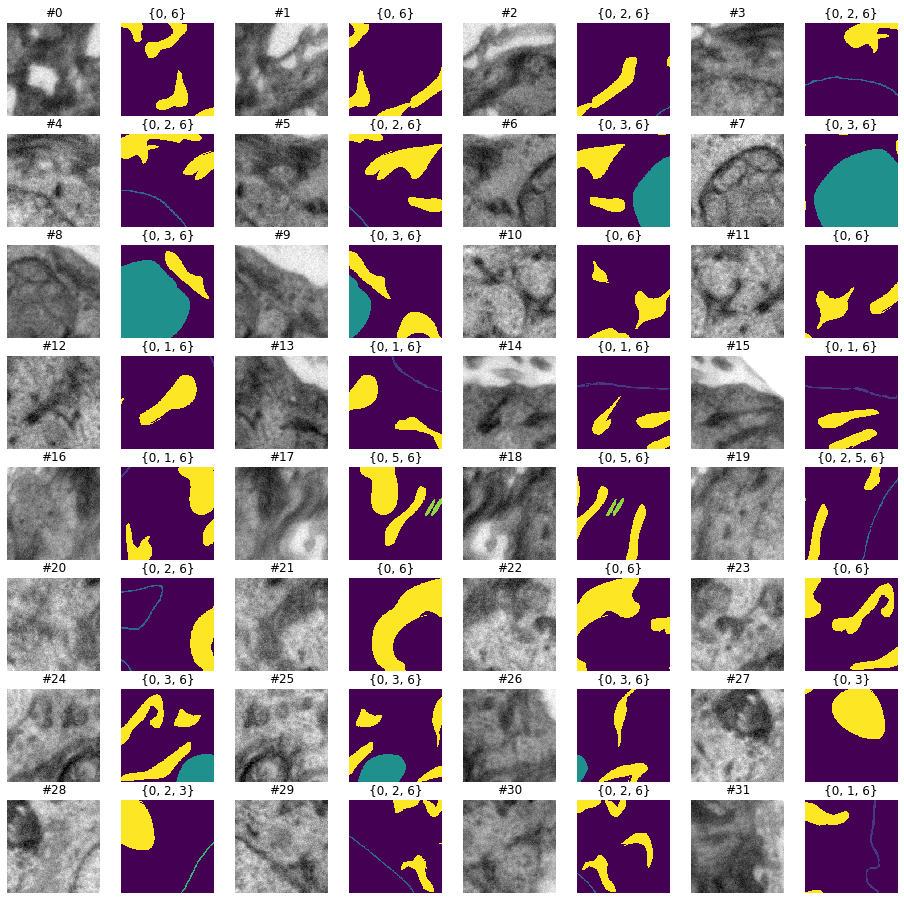

In [144]:
N, M, SZ, SHIFT, REPEAT = 8, 4, 2.0, 0, 1
n_img = N*M // REPEAT
fig, axes = plt.subplots(nrows=N, ncols=2*M, figsize=(SZ*M*2, SZ*N))
axes = axes.flatten()
axes_idx = 0
for i in range(n_img):
    for j in range(REPEAT):
        img, label = db[i+SHIFT]
        img = img[0]
        axes[axes_idx].imshow(img, cmap='gray')
        axes[axes_idx].set_title(f'#{i}')
        axes[axes_idx+1].imshow(label)
        axes[axes_idx+1].set_title(set(list(label.flatten())))
        axes_idx += 2
        
for ax in axes:
    ax.axis('off')

## Wavelets

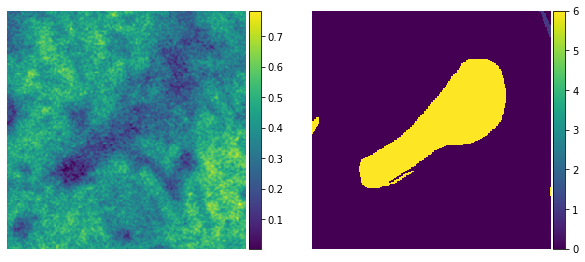

In [145]:
def add_colorbar(ax, pl):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pl, cax=cax)

img, label = db[12]
img = img[0]
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].axis('off')
pl = axes[0].imshow(img)
add_colorbar(axes[0], pl)

axes[1].axis('off')
pl = axes[1].imshow(label)
add_colorbar(axes[1], pl)

In [164]:
coeffs = pywt.wavedec2(img, 'db1', level=2)
print(len(coeffs))

3


In [165]:
print('Shapes')
for i, cs in enumerate(coeffs):
    if isinstance(cs, np.ndarray):
        print(f'{i}: {cs.shape}')
    elif isinstance(cs, tuple):
        for j, c in enumerate(cs):
            print(f'{i}, {j}: {c.shape}')
    else:
        print(f'{i}: {cs}')

Shapes
0: (64, 64)
1, 0: (64, 64)
1, 1: (64, 64)
1, 2: (64, 64)
2, 0: (128, 128)
2, 1: (128, 128)
2, 2: (128, 128)


In [166]:
def unpack(coeffs):
    coeff_list = []
    coeff_name = []
    for i, cs in enumerate(coeffs):
        if isinstance(cs, np.ndarray):
            coeff_list.append(cs)
            coeff_name.append(f'({i})')
        elif isinstance(cs, tuple):
            for j, c in enumerate(cs):
                coeff_list.append(c)
                coeff_name.append(f'({i}, {j})')
        else:
            print(f'WARNING {i} unknown type')
    return coeff_list, coeff_name

In [167]:
coeff_list, coeff_name = unpack(coeffs)
print(f'{len(coeff_list)} set of coefficients: {[coeff.shape for coeff in coeff_list]}')
print(coeff_name)

7 set of coefficients: [(64, 64), (64, 64), (64, 64), (64, 64), (128, 128), (128, 128), (128, 128)]
['(0)', '(1, 0)', '(1, 1)', '(1, 2)', '(2, 0)', '(2, 1)', '(2, 2)']


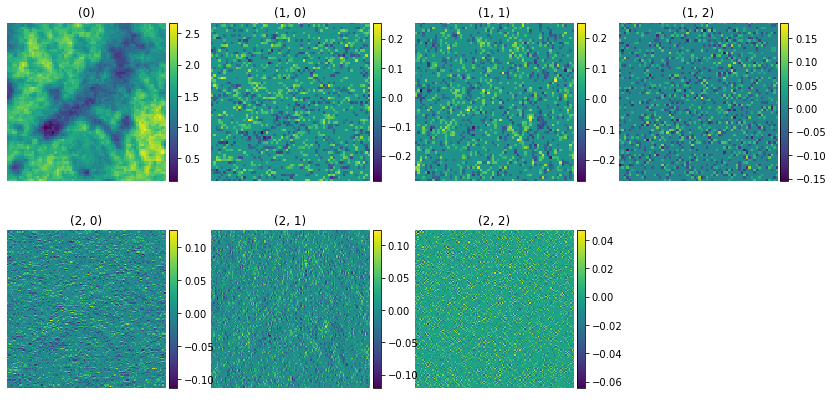

In [171]:
def plot_list_grid(l, names, M=4, SZ=3.5, ksigma=1.0):
    N = len(l) // M + (1 if len(l) % M != 0 else 0)
    fig, axes = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N)); axes = axes.flatten()
    for coeff, name, ax in zip(l, names, axes):
        coeff = np.array(coeff)
        if np.sum(coeff < 0.0) > 0.0:
            coeff[np.abs(coeff - np.mean(coeff)) < ksigma * np.std(coeff)] = np.mean(coeff)
        pl = ax.imshow(coeff)
        add_colorbar(ax, pl)
        ax.set_title(name)
    
    for ax in axes:
        ax.axis('off')

# def plot_coeffs_grid(l, names, M=4, SZ=3.5):
#     N = len(l) // M + (1 if len(l) % M != 0 else 0)
#     fig, axes = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N)); axes = axes.flatten()
#     for coeff, name, ax in zip(l, names, axes):
#         pl = ax.imshow(coeff)
#         add_colorbar(ax, pl)
#         ax.set_title(name)
    
#     for ax in axes:
#         ax.axis('off')

plot_list_grid(coeff_list, coeff_name, 4, 3.5)

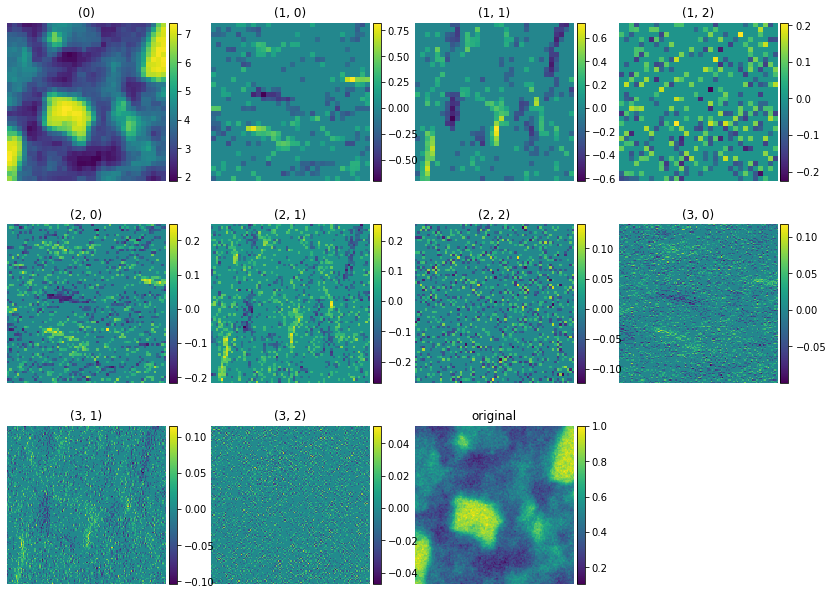

In [172]:
def test_wavelet_img(img, wavelet, level):
    # fit wavelet
    coeff_list, coeff_name = unpack(pywt.wavedec2(img, wavelet, level=level))
    coeff_list.append(img)
    coeff_name.append('original')
    
    # plot result with original image
    plot_list_grid(coeff_list, coeff_name, 4, 3.5)

test_wavelet_img(db[0][0][0], 'haar', 3)

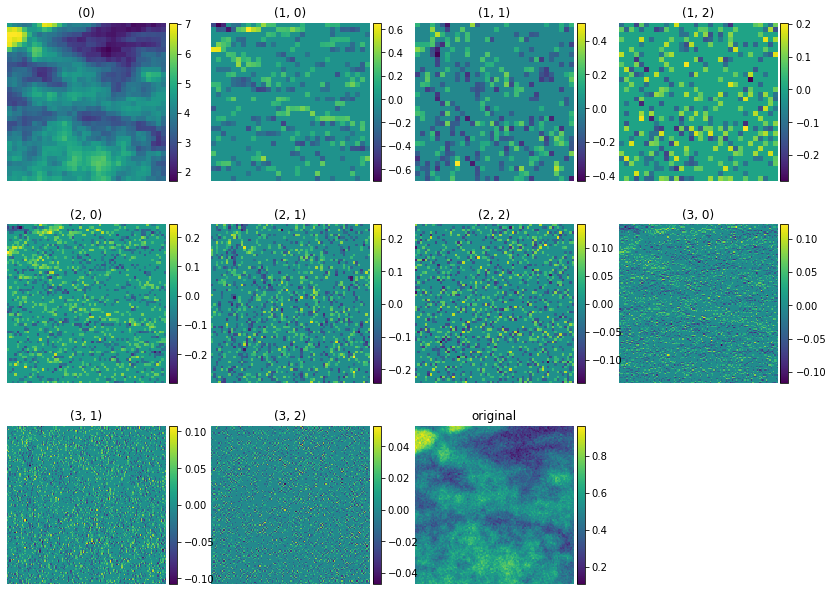

In [173]:
test_wavelet_img(db[3][0][0], 'db1', 3)

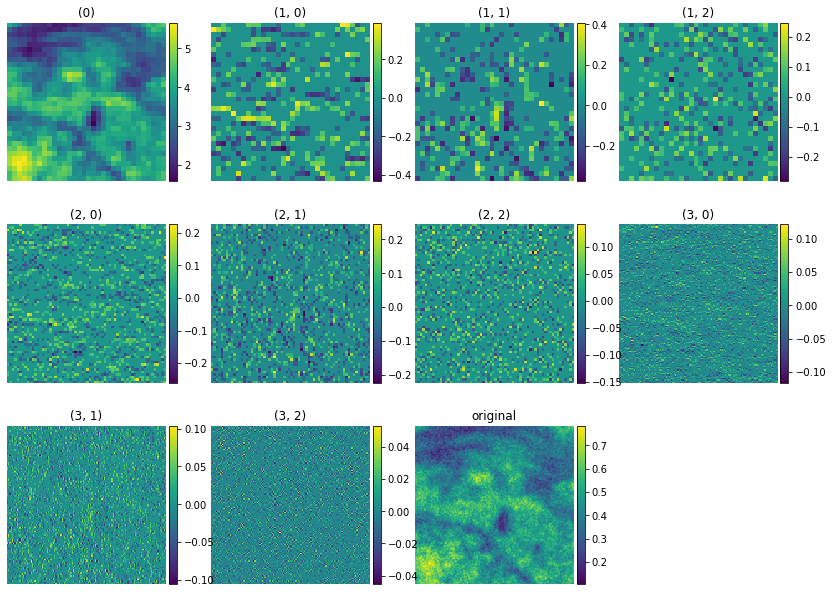

In [174]:
test_wavelet_img(db[4][0][0], 'db1', 3)

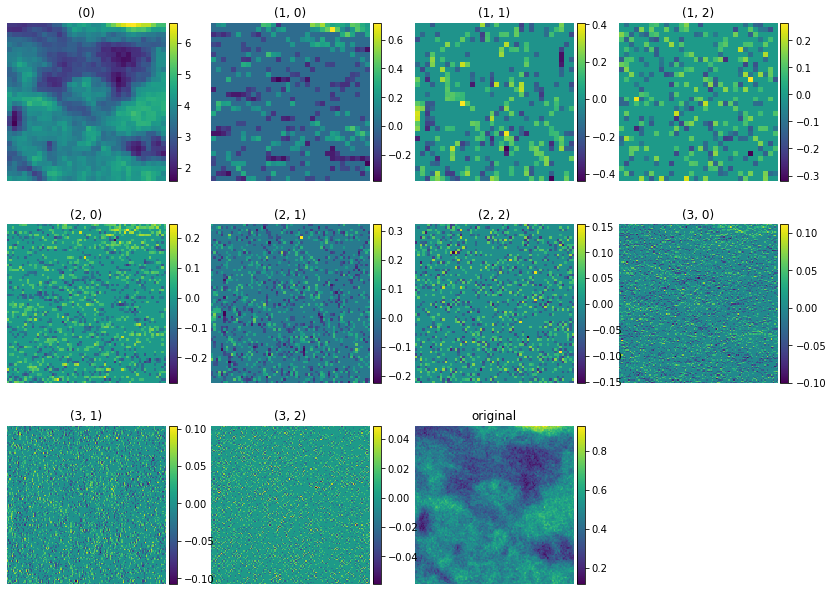

In [175]:
test_wavelet_img(db[5][0][0], 'db1', 3)

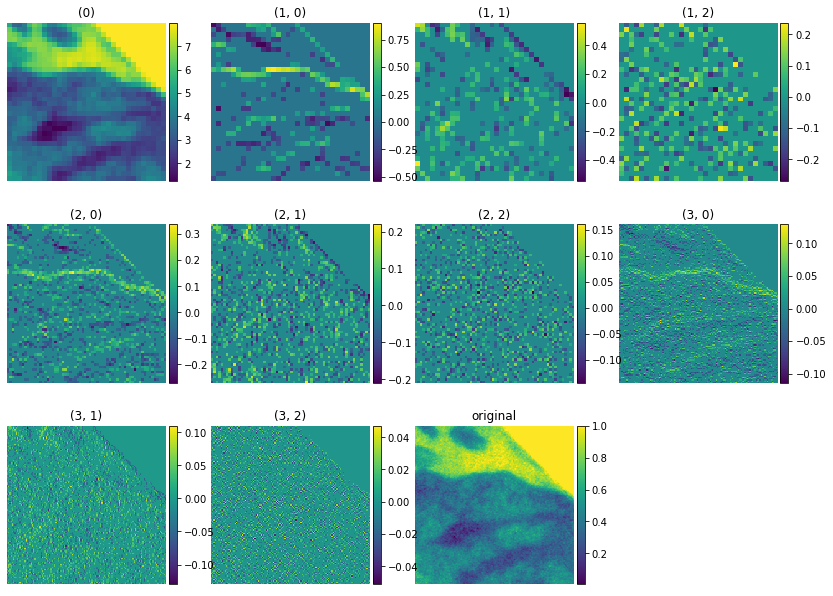

In [176]:
test_wavelet_img(db[15][0][0], 'db1', 3)

In [187]:
dba = udata.WaveletDataAugmemt(db, 'db1', 3)

In [189]:
x = dba[1][0]
print(x.shape)

torch.Size([11, 256, 256])


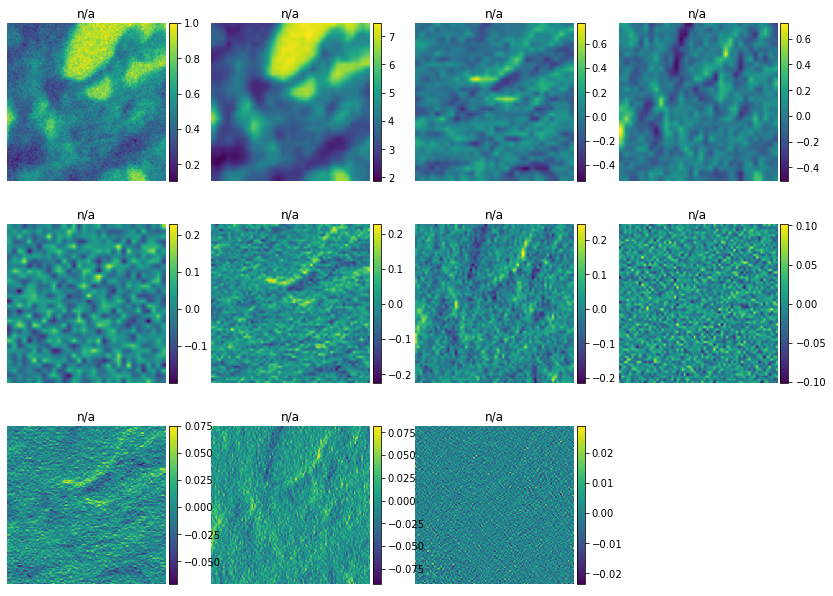

In [190]:
plot_list_grid(x, ["n/a" for _ in range(x.shape[2])], ksigma=0.0)